In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 250000000.0
lowcut = 10.0
highcut = 8000000.0

In [5]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

In [6]:
voltages = ['20220923_60V_laser_3725thres','20220923_61V_laser_3722thres','20220923_62V_laser_3722thres','20220923_63V_laser_3720thres','20220923_64V_laser_3718thres']
# voltages = ['20220926_bottom_65V_laser_thres3715','20220926_bottom_67V_laser_thres3712','20220926_bottom_69V_laser_thres3710/','20220926_bottom_71V_laser_thres3706/','20220926_bottom_73V_laser_thres3703/']

0 20220923_60V_laser_3725thres
Peak search with width=10 ...
Found 6 peaks
2.5265622308422824 0.01492624165767795


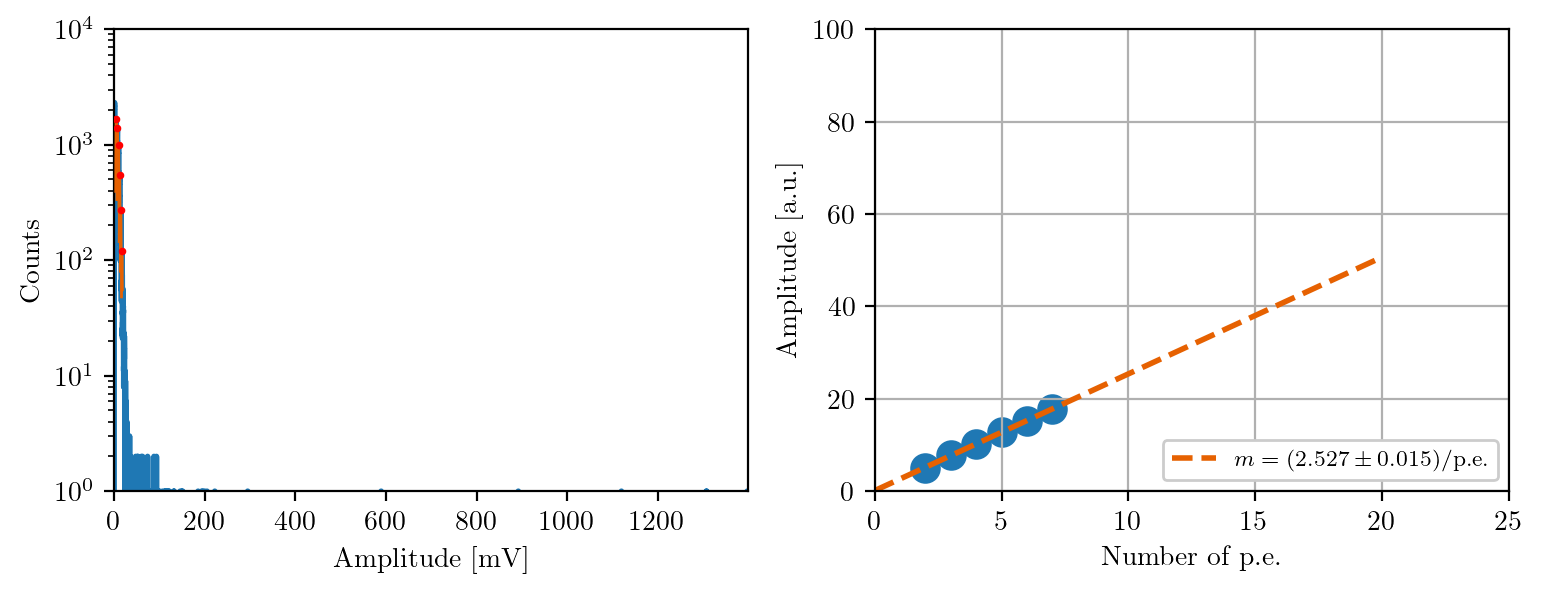

0 20220923_61V_laser_3722thres
Peak search with width=10 ...
Found 8 peaks
3.0465073539451426 0.01798506119497847


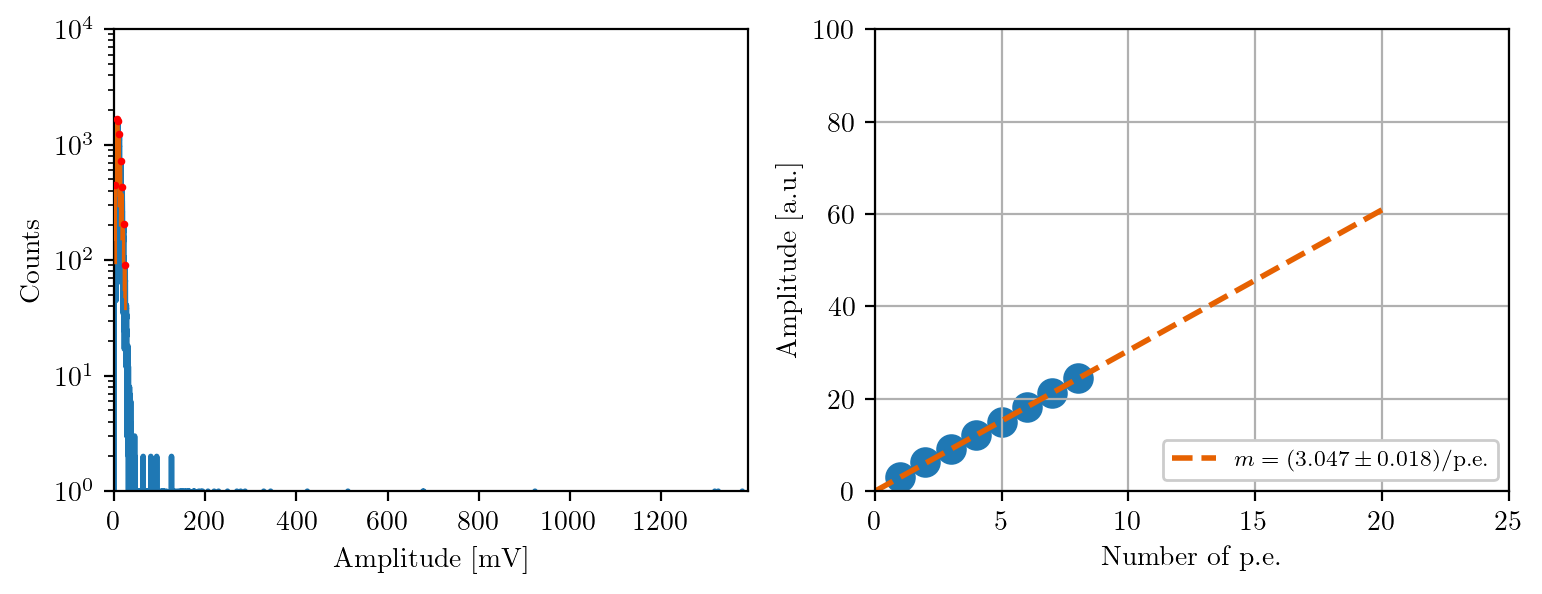

0 20220923_62V_laser_3722thres
Peak search with width=10 ...
Found 10 peaks
3.54268831059503 0.015903198679365897


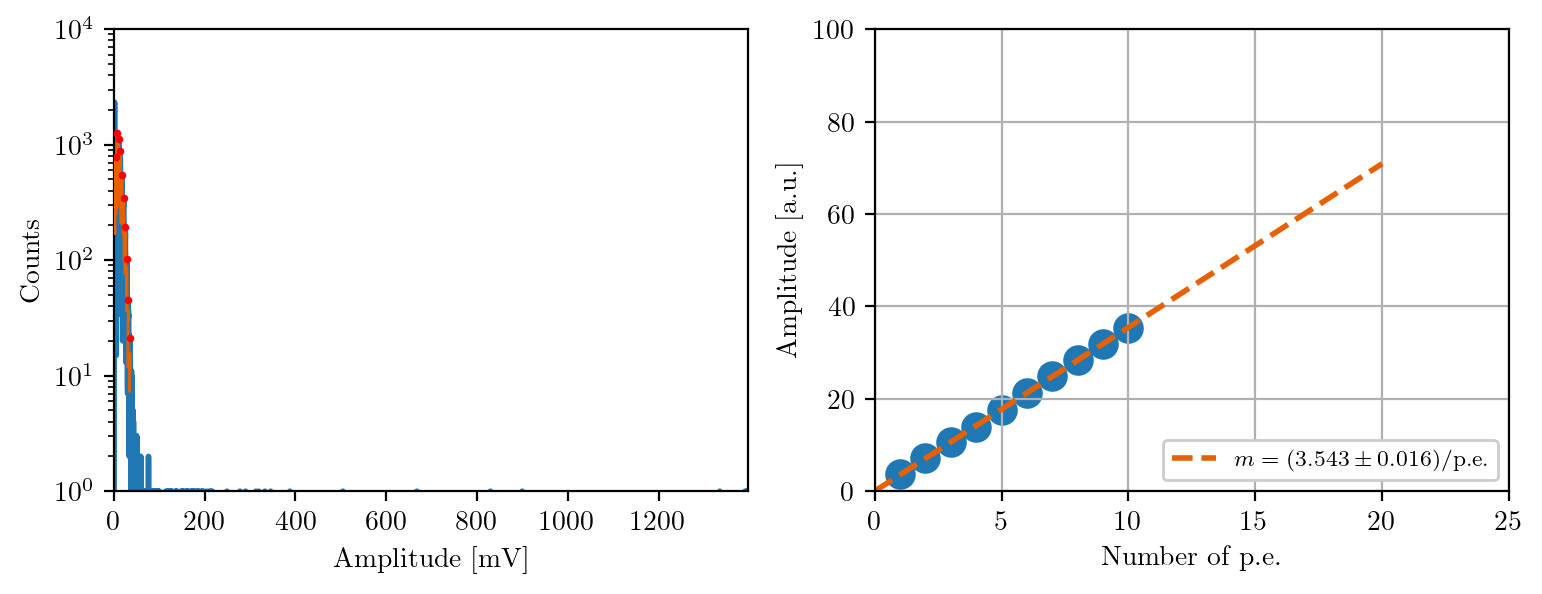

0 20220923_63V_laser_3720thres
Peak search with width=10 ...
Found 10 peaks
4.0539471081123715 0.014520880714553508


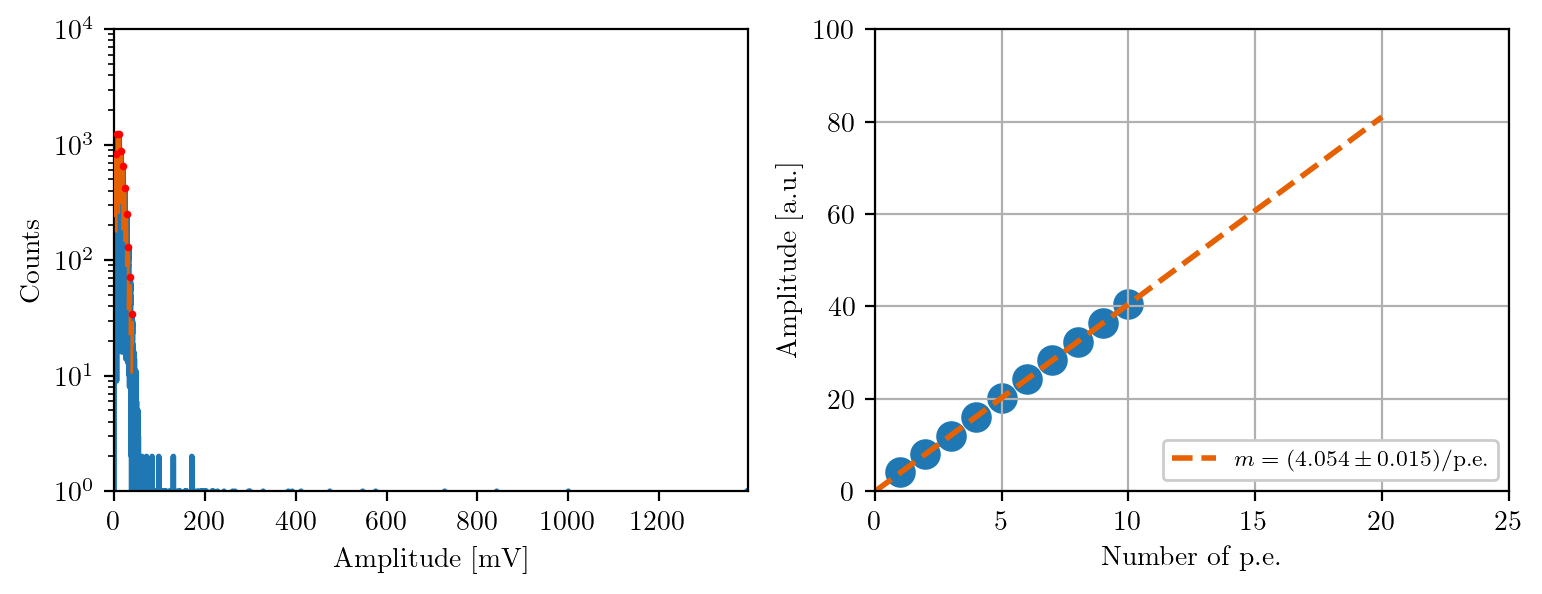

0 20220923_64V_laser_3718thres
Peak search with width=10 ...
Found 10 peaks
4.562607760111478 0.012633104045200298


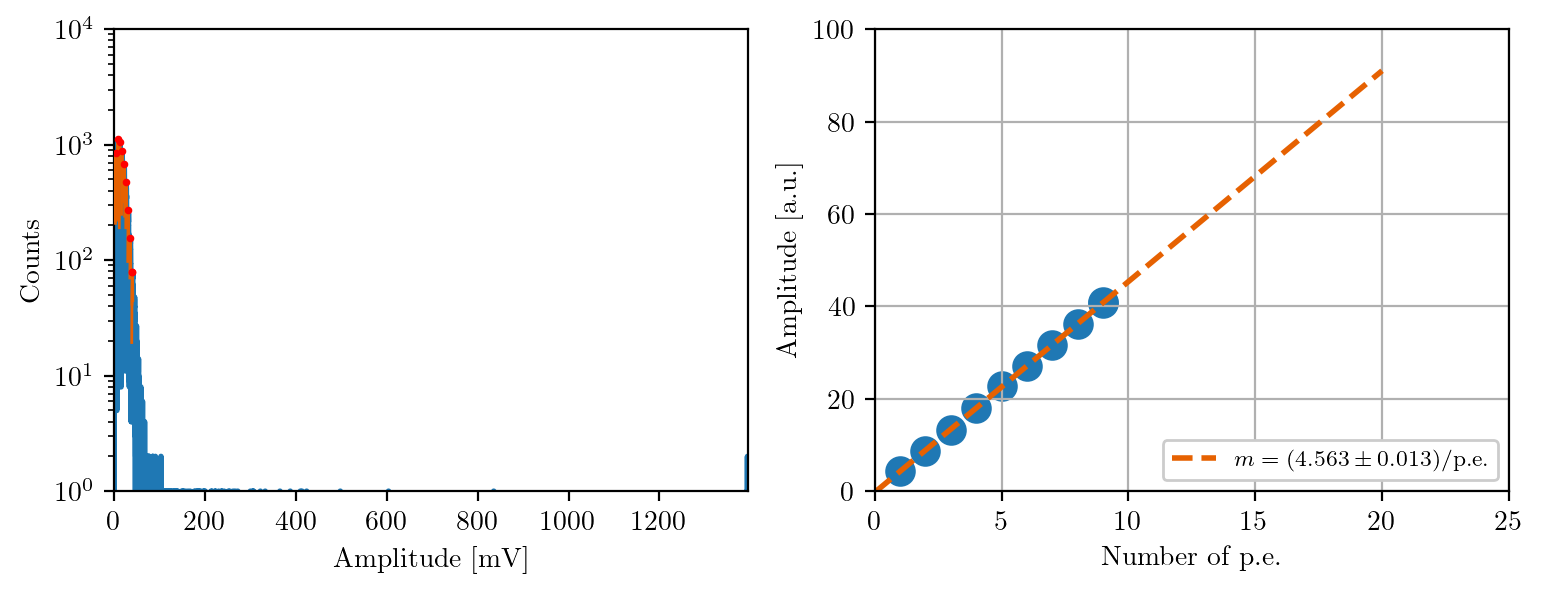

1 20220923_60V_laser_3725thres
Peak search with width=10 ...
Found 8 peaks
2.4346011972185426 0.0069476939071359016


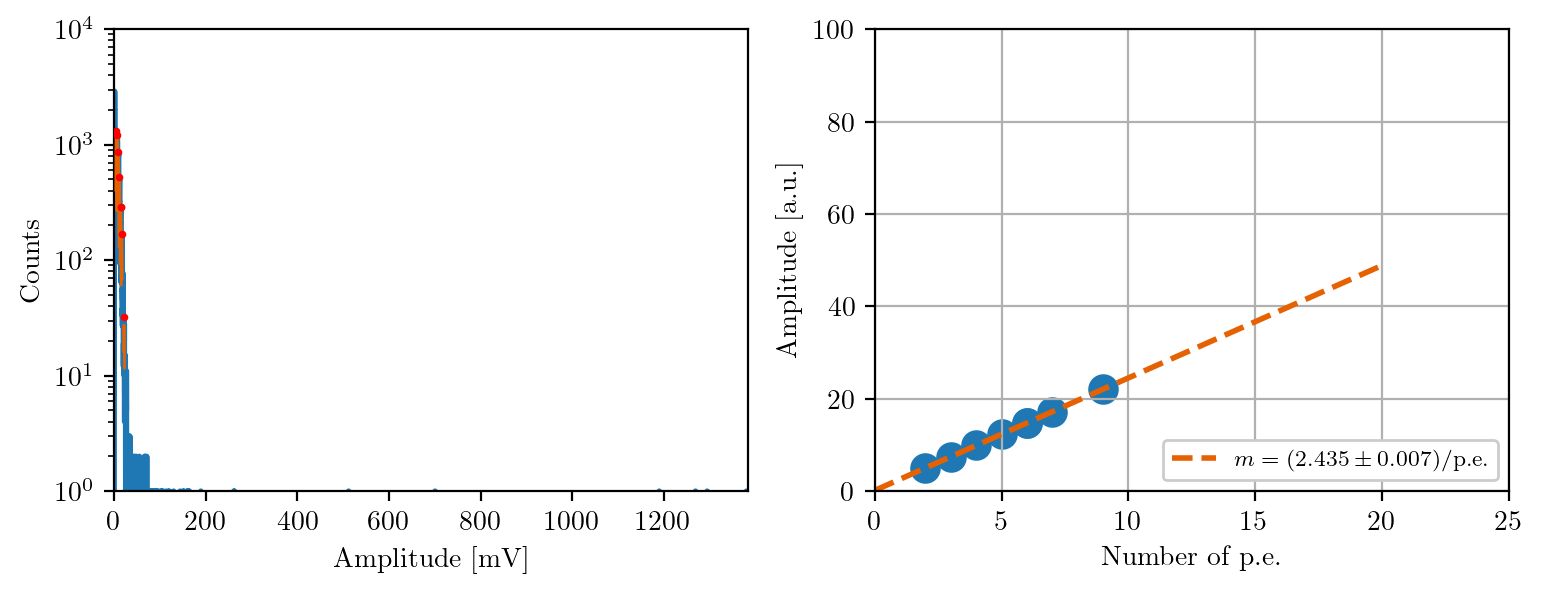

1 20220923_61V_laser_3722thres
Peak search with width=10 ...
Found 8 peaks
2.9040034198549898 0.008459671919601794


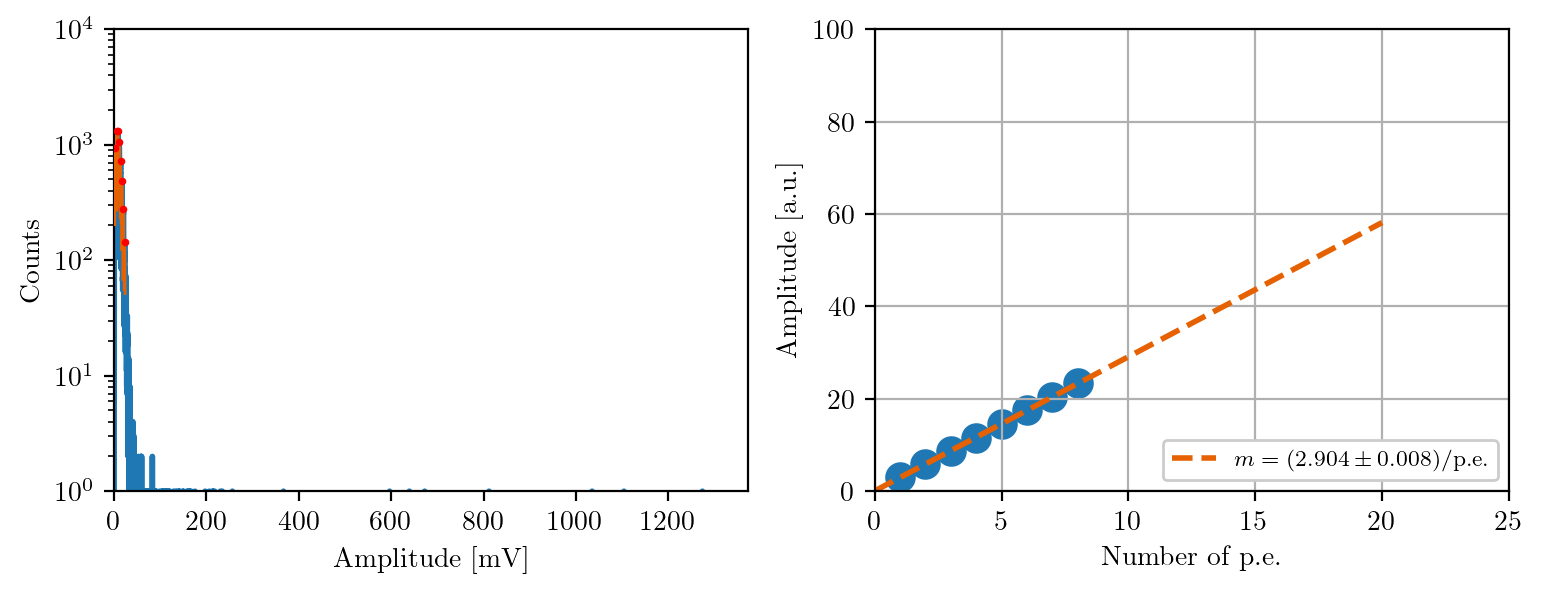

1 20220923_62V_laser_3722thres
Peak search with width=10 ...
Found 9 peaks
3.3814439676885155 0.005775335668065842


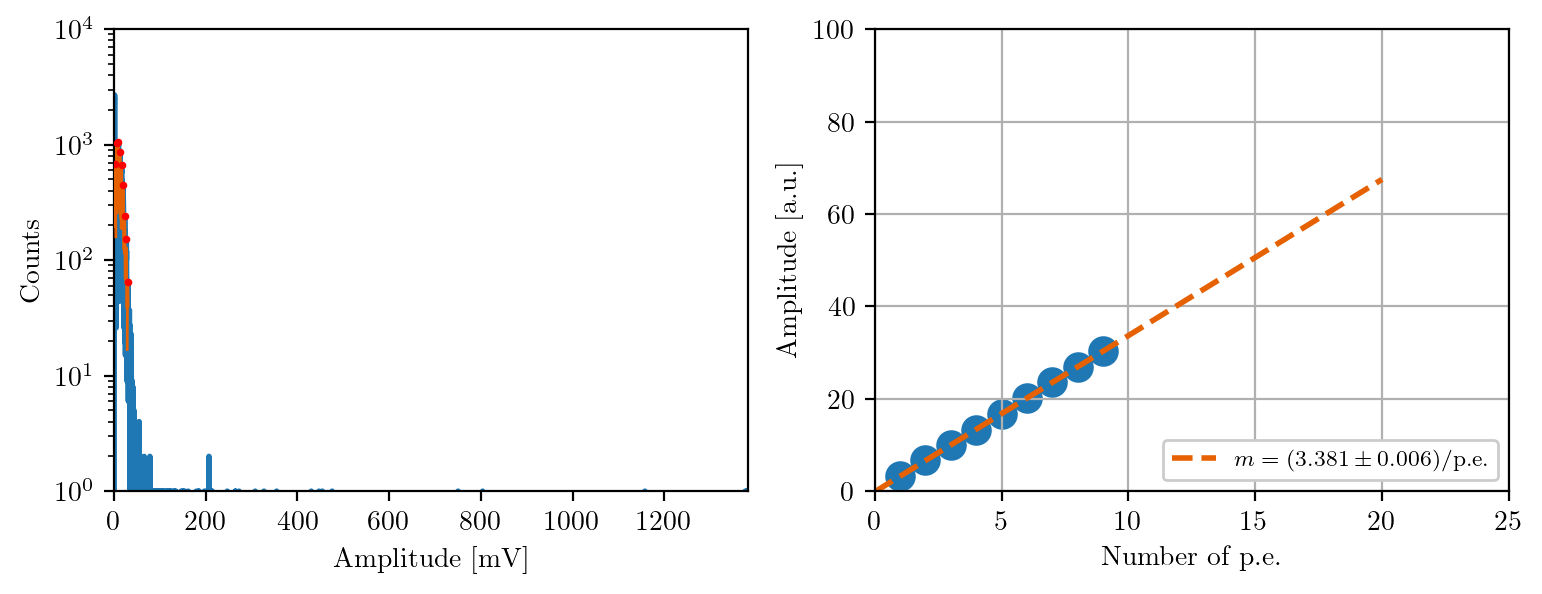

1 20220923_63V_laser_3720thres
Peak search with width=10 ...
Found 11 peaks
3.871350959176539 0.006372724670879555


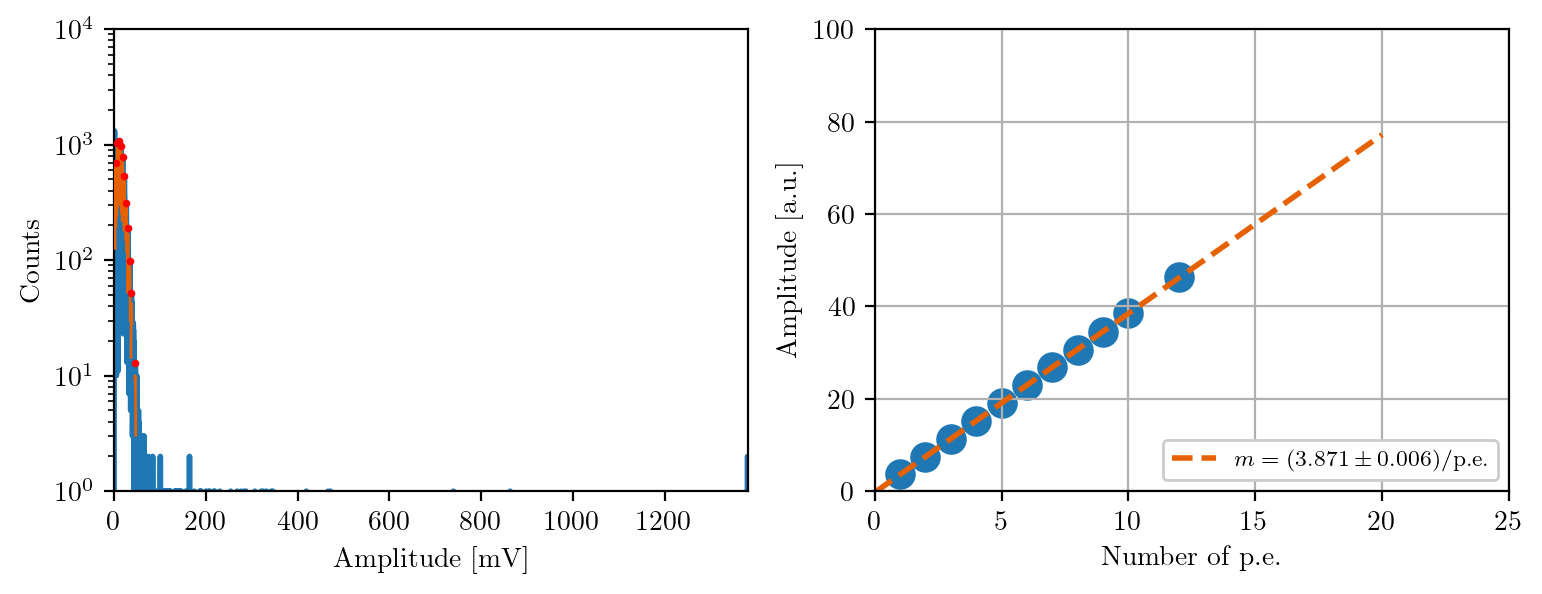

1 20220923_64V_laser_3718thres
Peak search with width=10 ...
Found 12 peaks
4.3633694913716 0.006662359826366164


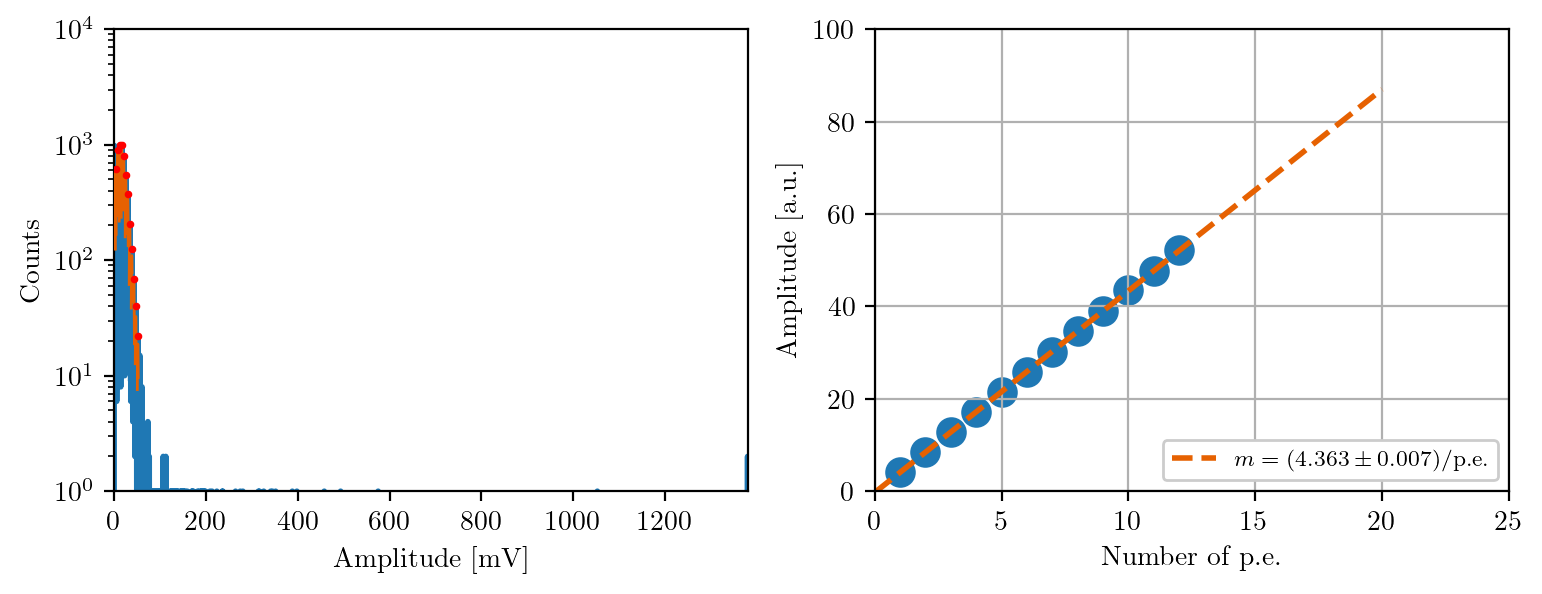

2 20220923_60V_laser_3725thres
Peak search with width=10 ...
Found 5 peaks
2.5652621117407266 0.006118683509705746


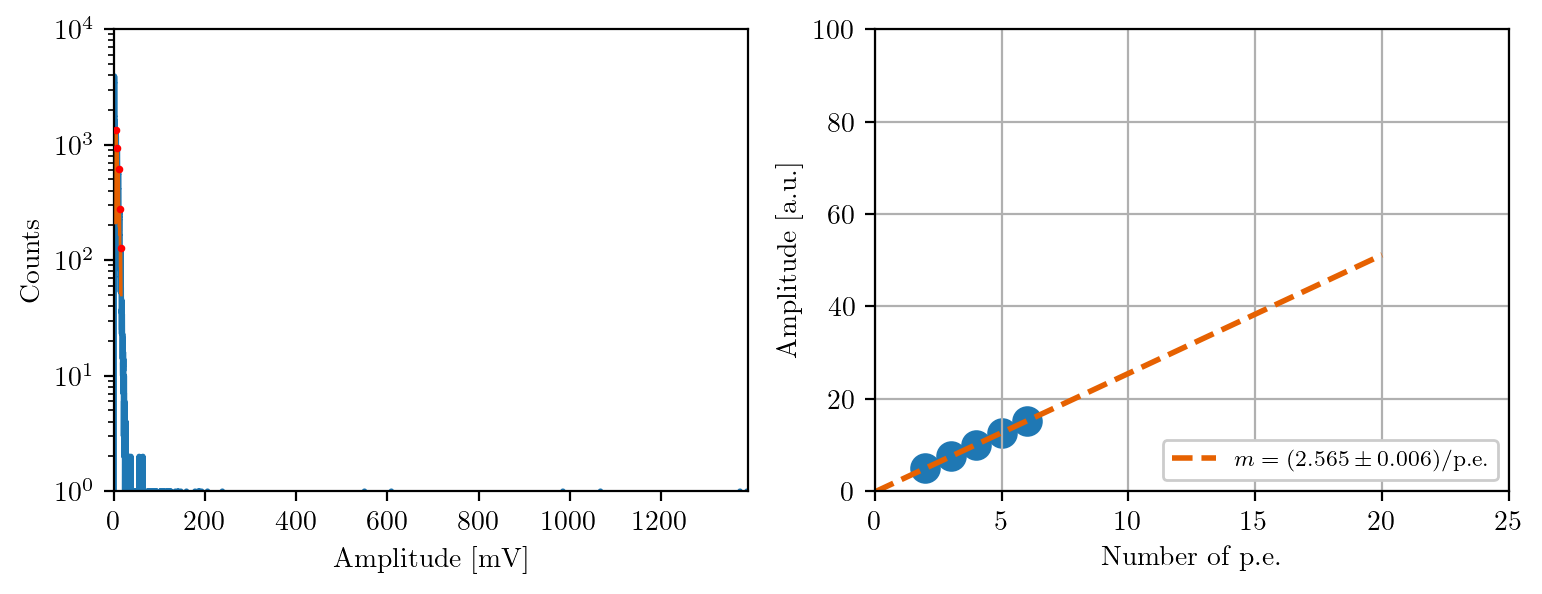

2 20220923_61V_laser_3722thres
Peak search with width=10 ...
Found 5 peaks
3.043019418705188 0.008427965596301596


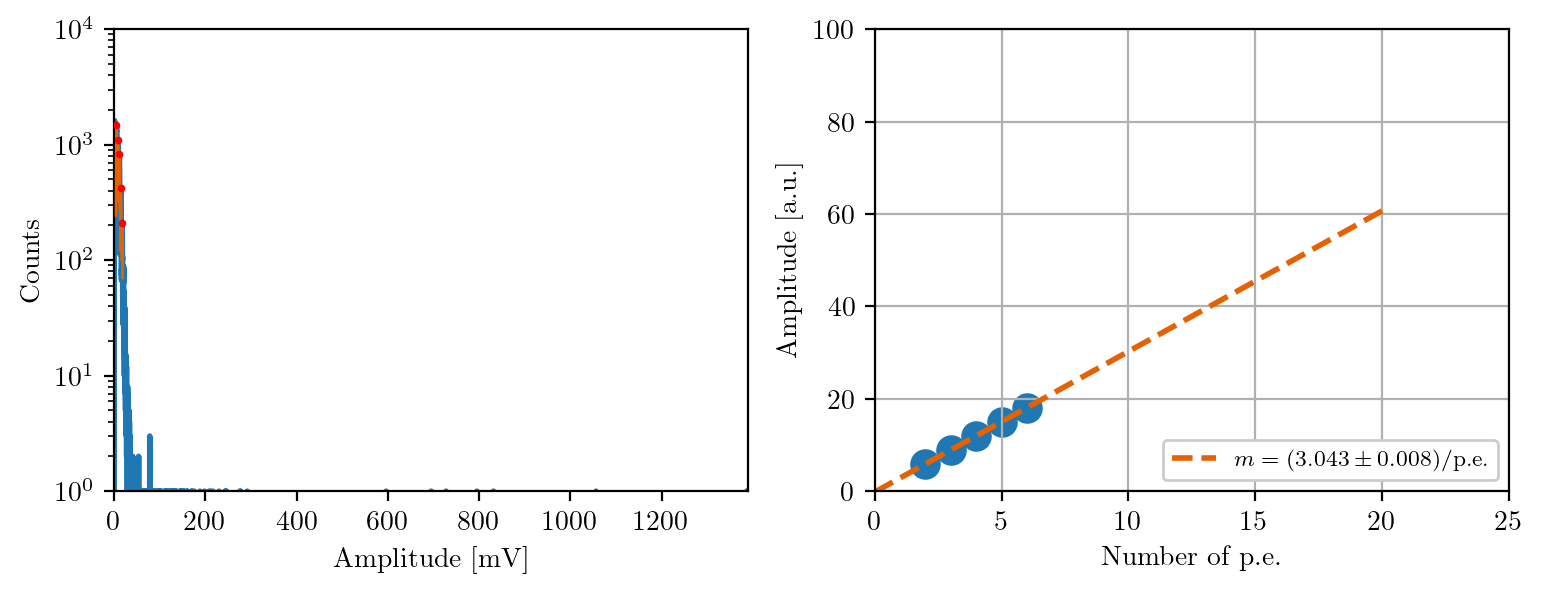

2 20220923_62V_laser_3722thres
Peak search with width=10 ...
Found 7 peaks
3.4941309932761384 0.00835866951147424


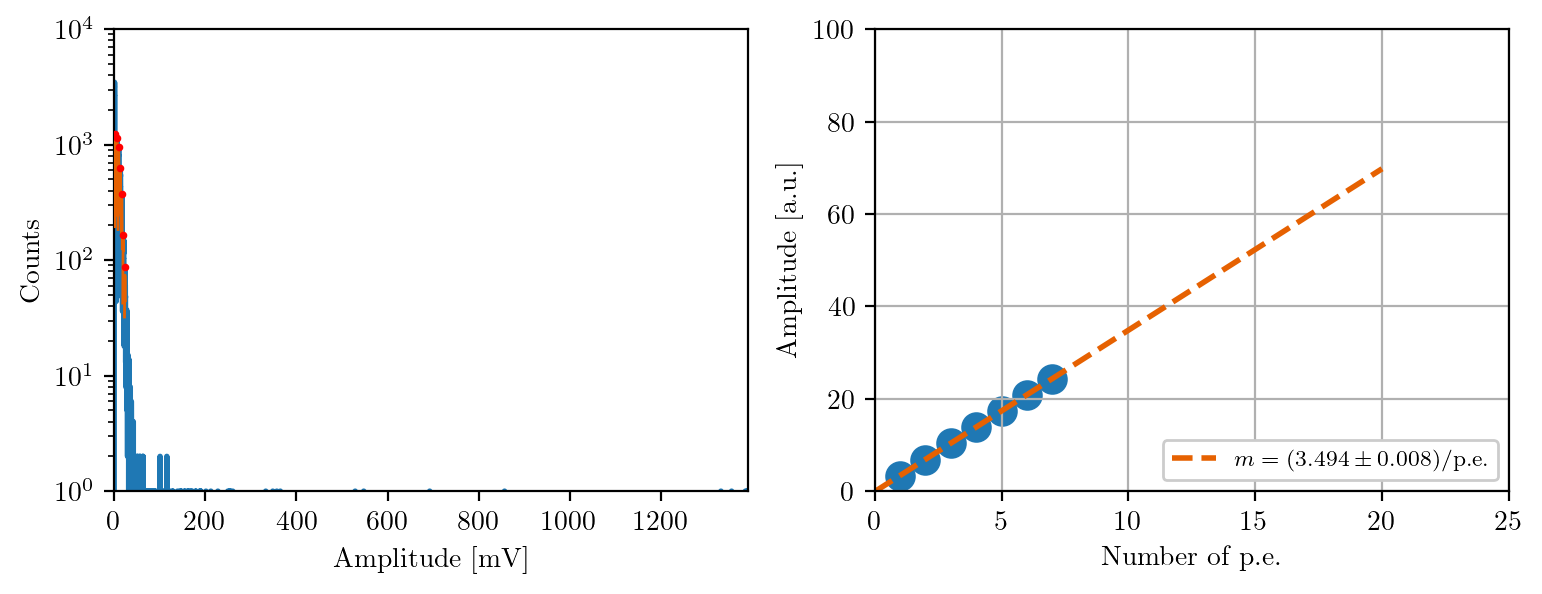

2 20220923_63V_laser_3720thres
Peak search with width=10 ...
Found 7 peaks
3.9888314900515143 0.006700186675993029


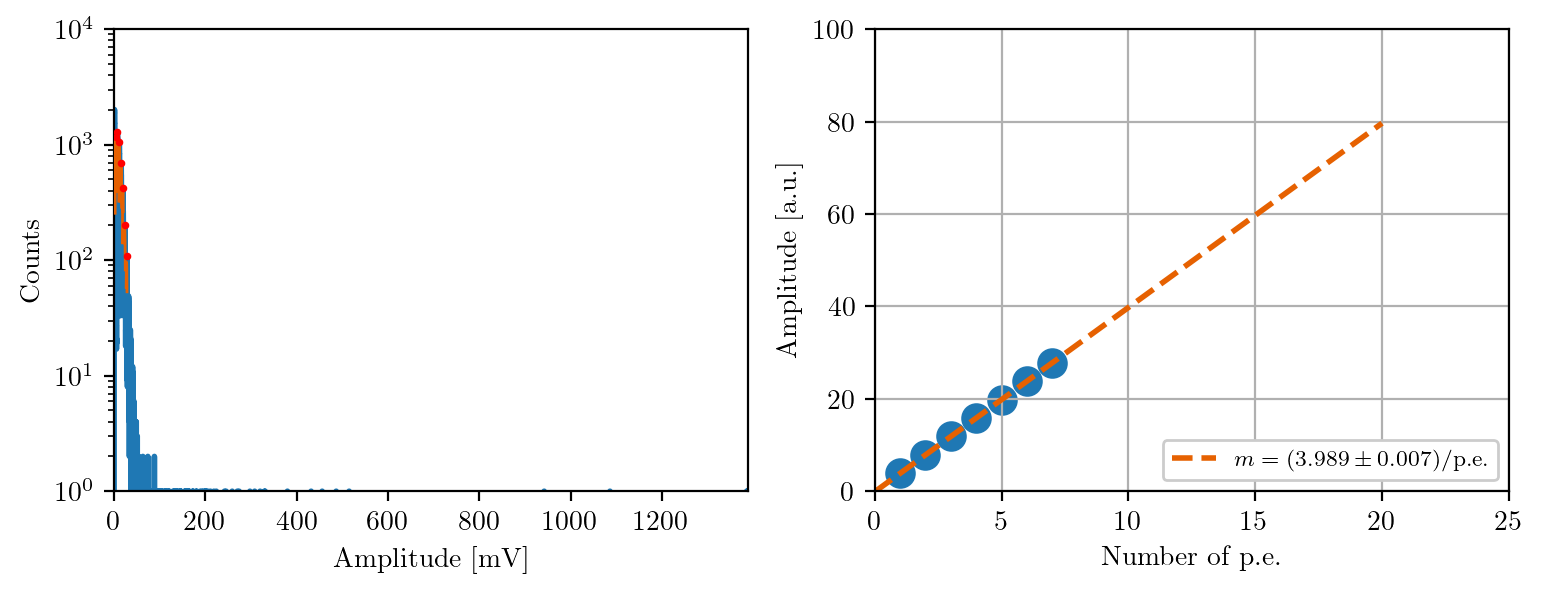

2 20220923_64V_laser_3718thres
Peak search with width=10 ...
Found 9 peaks
4.504339146410269 0.012219442548031059


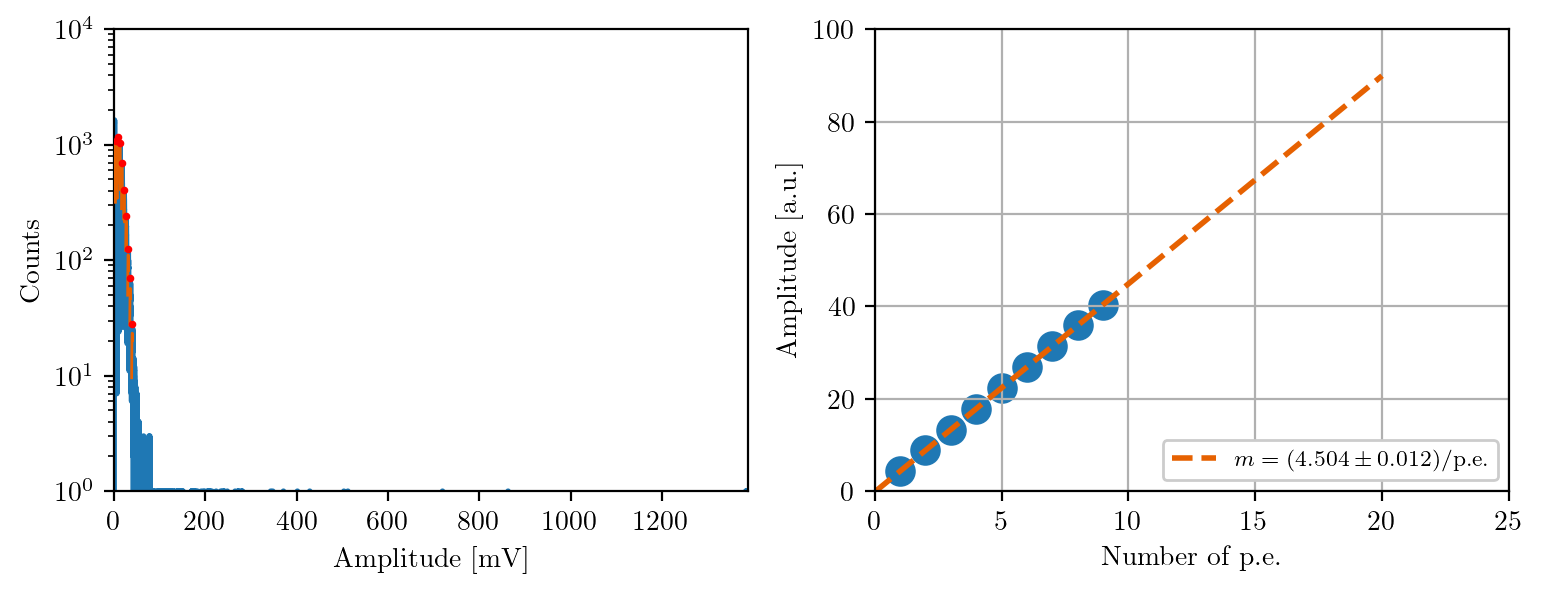

3 20220923_60V_laser_3725thres
Peak search with width=10 ...
Peak search with width=9 ...
Found 4 peaks
2.532229846378047 0.015602704876001674


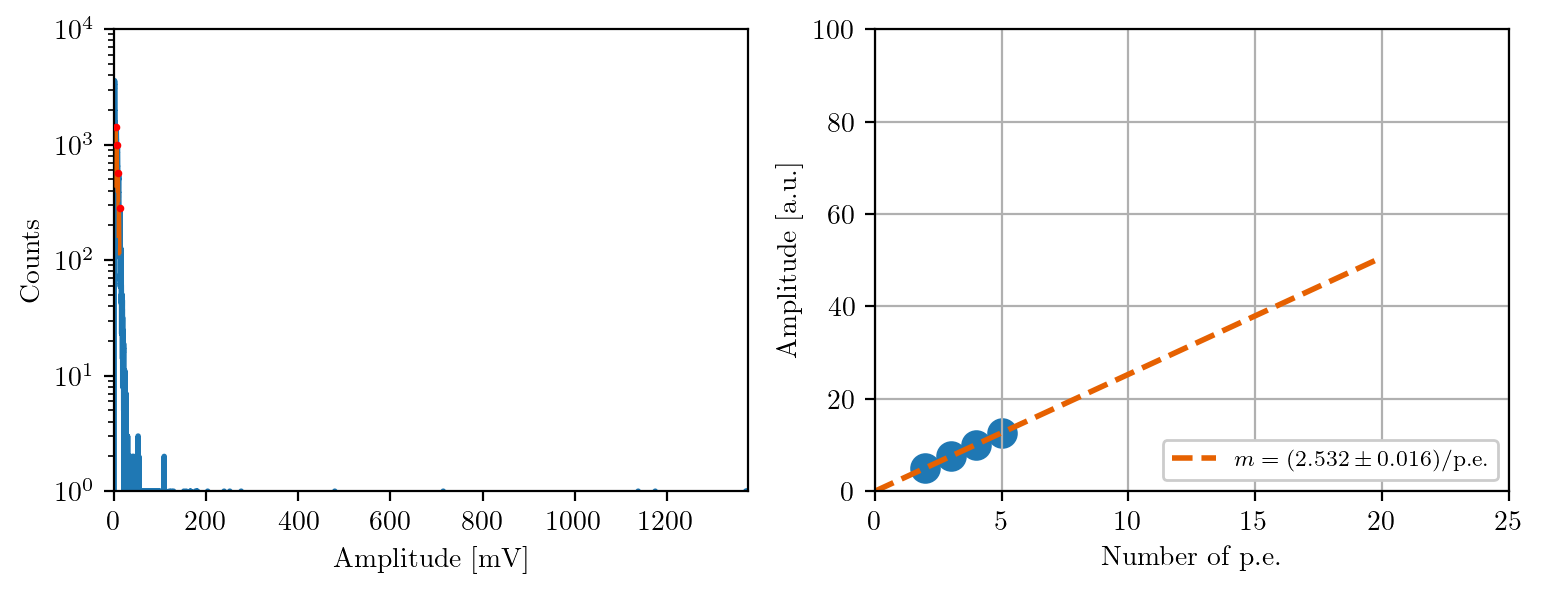

3 20220923_61V_laser_3722thres
Peak search with width=10 ...
Found 7 peaks
3.0548103451045923 0.01225673600849036


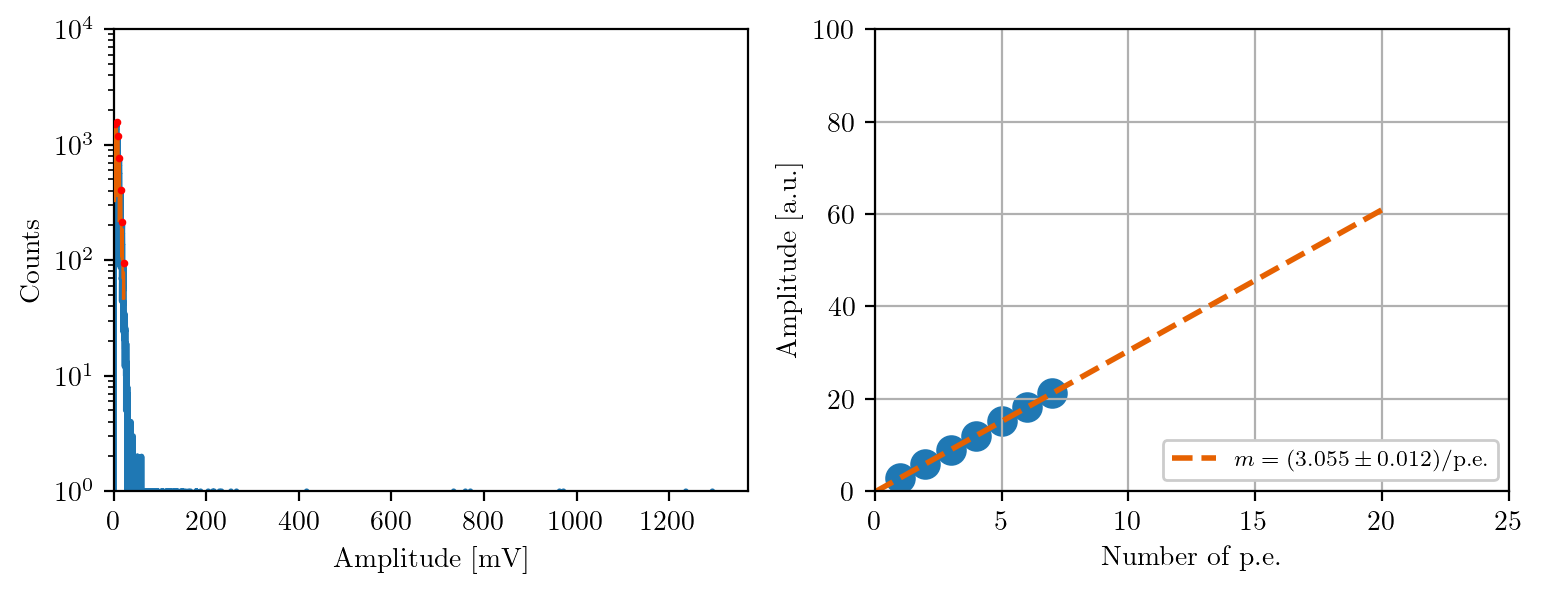

3 20220923_62V_laser_3722thres
Peak search with width=10 ...
Found 8 peaks
3.5421280964456017 0.007668537142456187


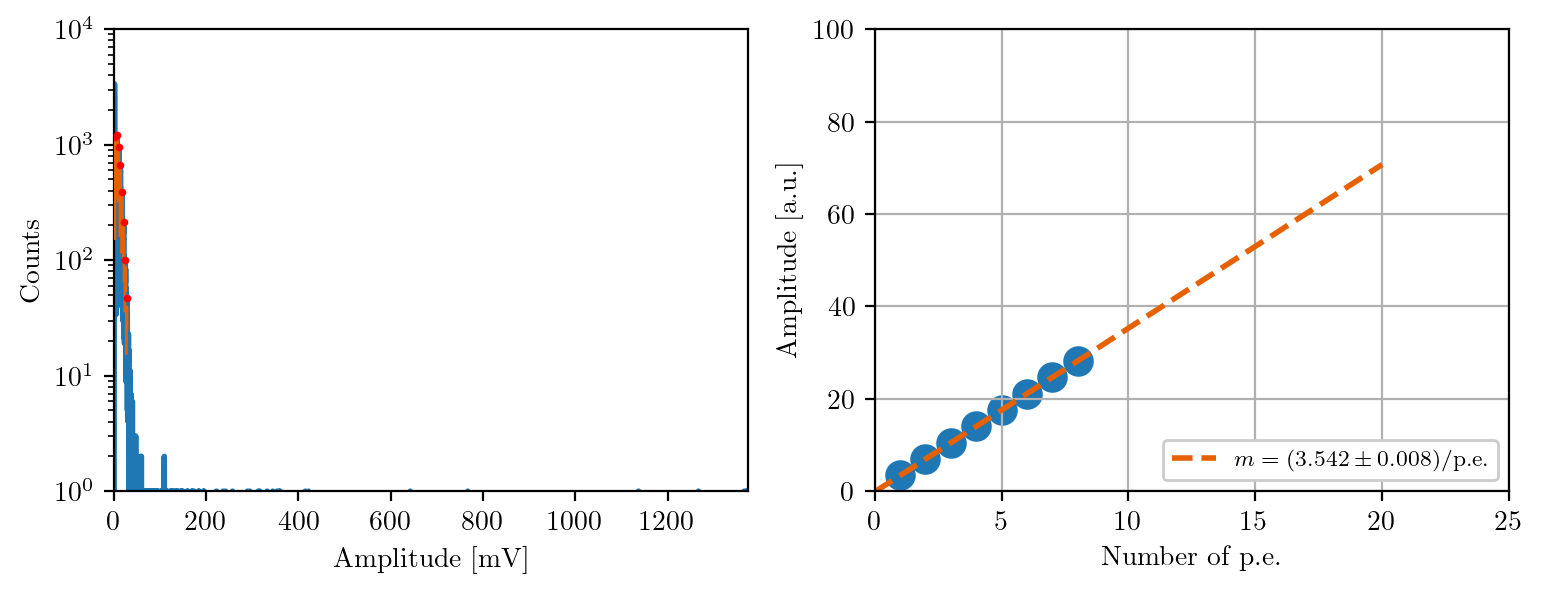

3 20220923_63V_laser_3720thres
Peak search with width=10 ...
Found 8 peaks
4.041392720440102 0.007175547578492966


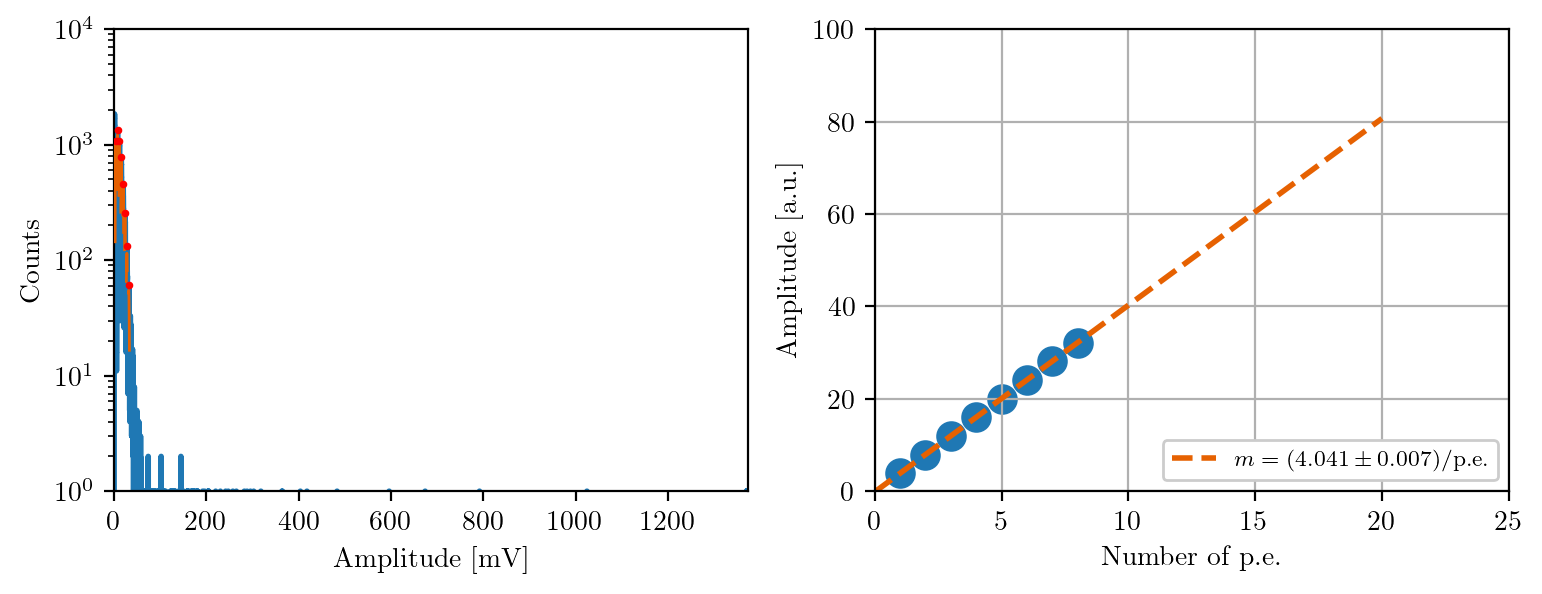

3 20220923_64V_laser_3718thres
Peak search with width=10 ...
Found 10 peaks
4.564508646551823 0.006854700742267014


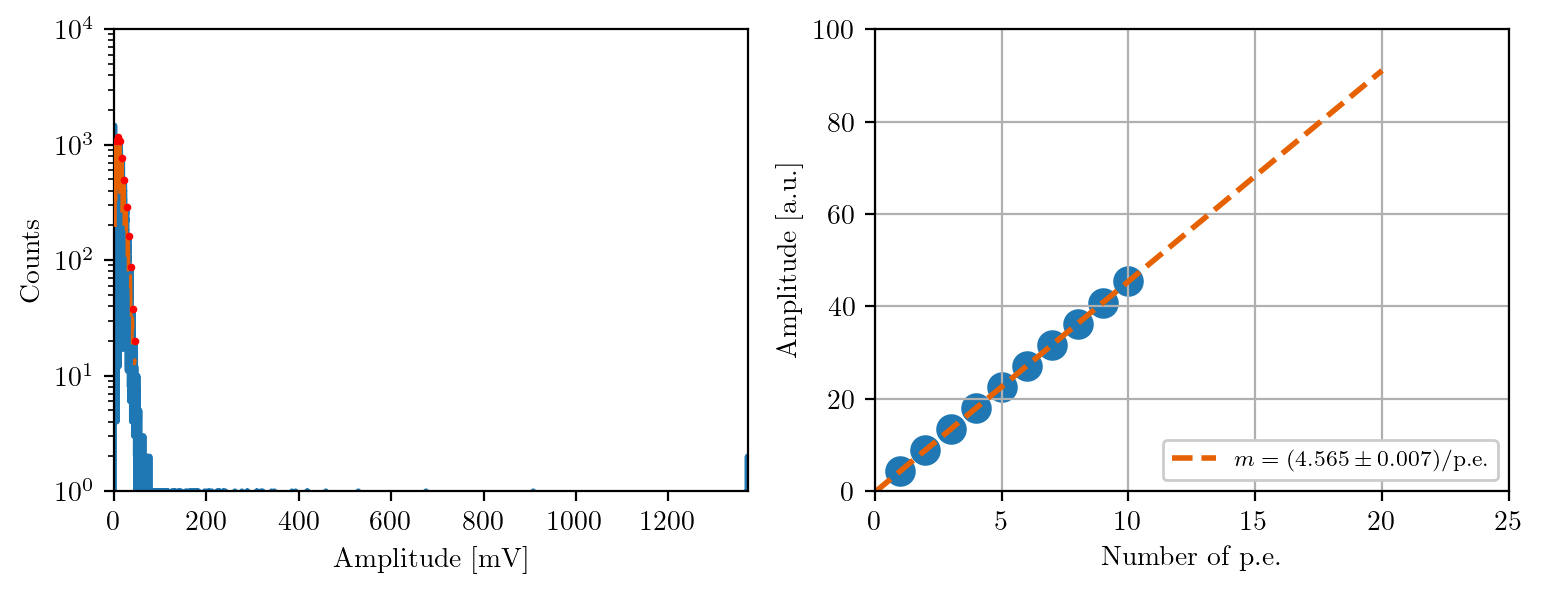

In [7]:
gains_all = {}
gains_err_all = {}
for ch in [0,1,2,3]:
    gains_all[ch] = []
    gains_err_all[ch] = []
    for volt in voltages: 
        print(ch, volt)
        
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        tt = np.arange(0,0.004*2048,0.004)

        amp = [] 
        integral = []

        for i,wvf in enumerate(traces):
            # if i % 10000 == 0:
            #     print(i)
            traces[i] = traces[i] - np.mean(traces[i][:100])
            traces[i] = butter_bandpass_filter(traces[i], lowcut, highcut, fs, order=3)
            amp.append(np.min(traces[i]))
            integral.append(np.sum(traces[i]))
        
        amp = np.array(amp)
        integral = np.array(integral)

        h,hx = np.histogram(np.abs(amp), bins=np.arange(0,np.max(np.abs(amp)),.1))
        # h,hx = np.histogram(integral, bins=np.arange(0,2000,1))
        # pp,pdict = find_peaks(h, prominence=10, width=10, distance=5)

        pp = []
        width = 10
        while len(pp)<=3:
            print('Peak search with width={} ...'.format(width))
            pp,pdict = find_peaks(h, prominence=10, width=width)
            
            width -= 1

        print("Found {} peaks".format(len(pp)))
        fig, ax = plt.subplots(figsize=(9,3), ncols=2,nrows=1)
        ww = 10
        fit_p = []
        fit_c = []

        for x in pp: 
            popt,pcov = curve_fit(gauss, hx[:-1][x-ww:x+ww], h[x-ww:x+ww], p0=[h[x], hx[:-1][x], 2], maxfev=10000)
            ax[0].plot(hx[:-1][x-ww:x+ww], gauss(hx[:-1][x-ww:x+ww], *popt), color=colors[1], lw=1, zorder=10)
            fit_p.append(popt)
            fit_c.append(pcov)

        ax[0].step(hx[:-1],h, where='post')
        ax[0].scatter(hx[pp], h[pp], color='r', s=3, zorder=10)
        ax[0].set_xlabel('Amplitude [mV]')
        ax[0].set_ylabel('Counts')
        ax[0].set_yscale('log')
        ax[0].set_xlim(0,np.max(hx))
        ax[0].set_ylim(1e0,1e4)

        # quick estimate of gain
        gain = np.median(np.diff(np.array(fit_p)[:,1]))
        # get peak number
        peak_num = np.round(np.array(fit_p)[:,1]/gain)
        
        popt,pcov = curve_fit(line, peak_num, np.array(fit_p)[:,1])
        perr = np.sqrt(np.diag(pcov))
        print(popt[0], perr[0])

        gains_all[ch].append(popt[0])
        gains_err_all[ch].append(perr[0])
        xfit = np.linspace(0,20,100)

        ax[1].grid()
        ax[1].plot(xfit, line(xfit, *popt), color=colors[1], ls='--', label=r'$m=({:.3f}\pm {:.3f})$/p.e.'.format(popt[0], perr[0]))
        ax[1].scatter(peak_num, np.array(fit_p)[:,1])
        ax[1].set_xlabel('Number of p.e.')
        ax[1].set_ylabel('Amplitude [a.u.]')
        ax[1].set_xlim(0,25)
        ax[1].set_ylim(0,100)
        ax[1].legend(loc='lower right')
        # plt.savefig('gain_ch{}_{}.pdf'.format(ch, volt))
        plt.show()

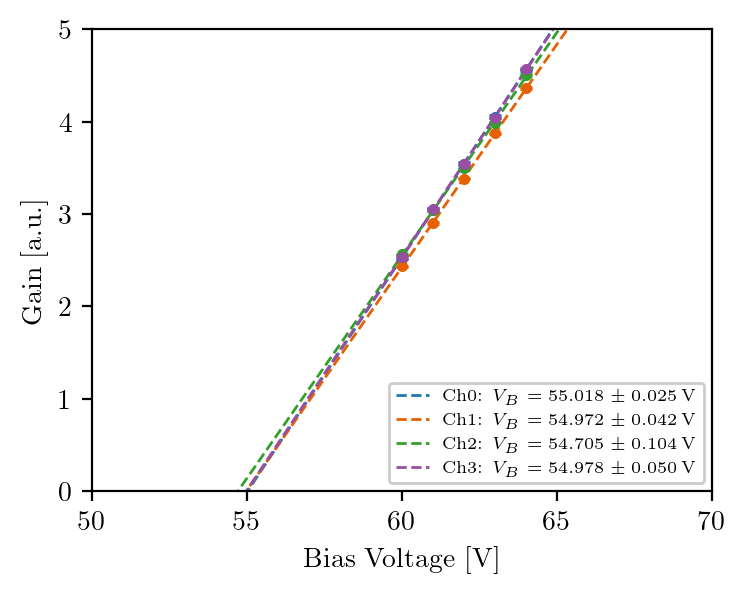

In [8]:
voltage = np.arange(60,65,1)

def b_line(x,a,b):
    return a*(x-b)

    
plt.figure()

v_bd = []
v_bd_err = []
for i in range(4):
    popt,pcov = curve_fit(b_line, voltage, gains_all[i])
    perr = np.sqrt(np.diag(pcov))
    xfit = np.linspace(50,70,100)
    breakdown = r'Ch{}: $V_B={:.3f}\pm{:.3f}\,$V'.format(i, popt[1], perr[1])

    v_bd.append(popt[1])
    v_bd_err.append(perr[1])

    plt.plot(xfit, b_line(xfit, *popt), color=colors[i], label=breakdown, lw=1, ls='--')
    plt.errorbar(voltage, gains_all[i], yerr=gains_err_all[i], color=colors[i], ls='None', label='', marker='o', ms=3)

plt.xlabel('Bias Voltage [V]')
plt.ylabel('Gain [a.u.]')
plt.xlim(50,70)
plt.ylim(0,5)
plt.legend(loc='lower right', fontsize=6)
plt.savefig('breakdown_ch0.pdf')
plt.show()

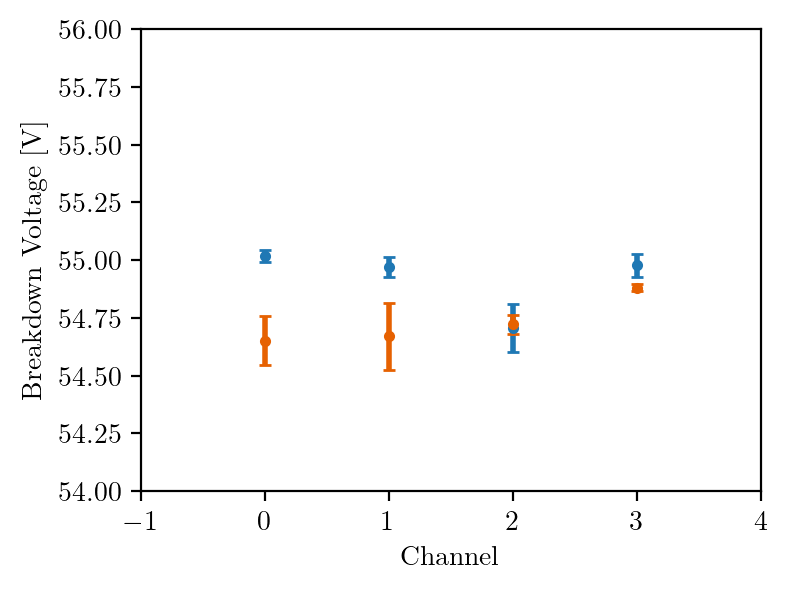

In [20]:
allan_v = [54.651,54.671,54.722,54.881]
allan_err = [0.106,0.145,0.042,0.016]

plt.figure()
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage [V]')
plt.xlim(-1,4)
plt.ylim(54,56)
plt.errorbar(np.arange(0,4,1), v_bd, yerr=v_bd_err, ls='None', marker='o', ms=3)
plt.errorbar(np.arange(0,4,1), allan_v, yerr=allan_err, ls='None', marker='o', ms=3, label='Allan')

plt.show()

In [10]:
ch = 0
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_60V_laser_3725thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_61V_laser_3722thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_62V_laser_3722thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_63V_laser_3720thres/wave{}.dat".format(ch)
# fname = "/home/aj9512/jadwin-365/data/sipm/20220923_64V_laser_3718thres/wave{}.dat".format(ch)
fname = "/home/aj9512/jadwin-365/data/sipm/20220923_60V_scint_3710thres/wave{}.dat".format(ch)

In [11]:
dt = np.dtype('<H')
file = open(fname, 'rb')
traces = np.fromfile(file, dtype=dt, count=-1)
file.close()

In [12]:
traces = traces.reshape((-1,2048)).astype(float)
tt = np.arange(0,0.004*2048,0.004)

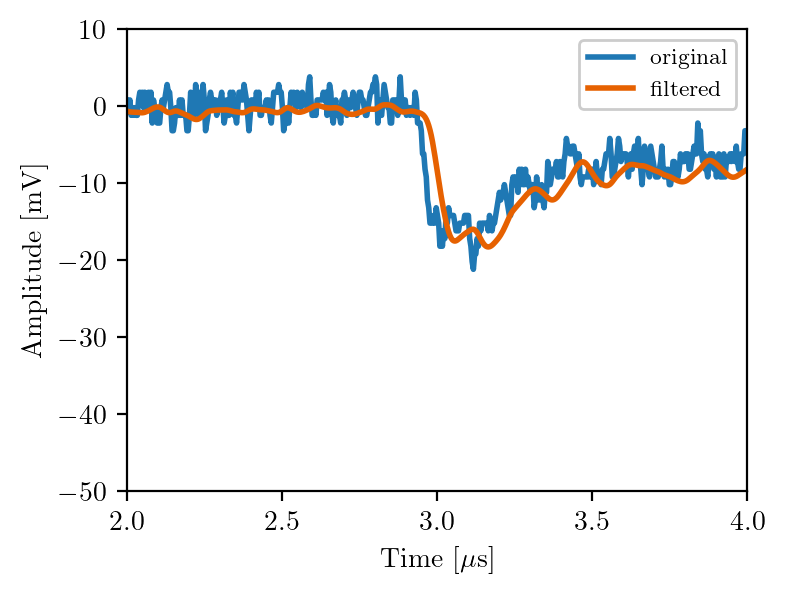

In [13]:
y = butter_bandpass_filter(traces[1000], lowcut, highcut, fs, order=3)

plt.figure()
plt.plot(tt, traces[1000]-np.mean(traces[1000][:100]), label='original')
plt.plot(tt, y-np.mean(y[100:200]), label='filtered')
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(2,4)
plt.ylim(-50, 10)
plt.legend(loc='upper right')
plt.show()

In [14]:
amp = [] 
integral = []

for i,wvf in enumerate(traces):
    if i % 10000 == 0:
        print(i)
    traces[i] = traces[i] - np.mean(traces[i][:100])
    traces[i] = butter_bandpass_filter(traces[i], lowcut, highcut, fs, order=3)
    amp.append(np.min(traces[i]))
    integral.append(np.sum(traces[i]))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [15]:
amp = np.array(amp)
integral = np.array(integral)

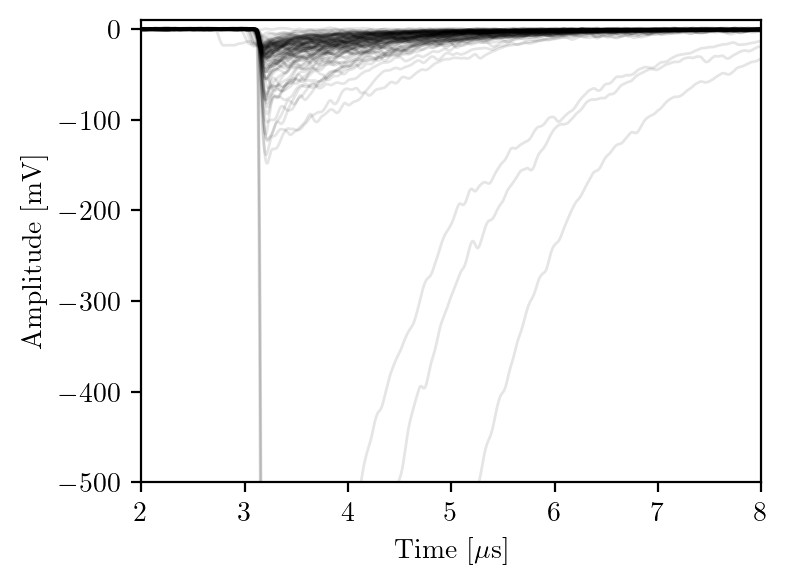

In [16]:
plt.figure()

for i,wvf in enumerate(traces[::1000]):
    plt.plot(tt, wvf, lw=1, color='k', alpha=0.1)
# plt.plot(tt, np.mean(traces, axis=0), color='r')
# plt.vlines(x=0.4*np.max(tt), ymin=-100, ymax=20, linestyles='--', lw=1)

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(2,8)
plt.ylim(-500, 10)
plt.show()

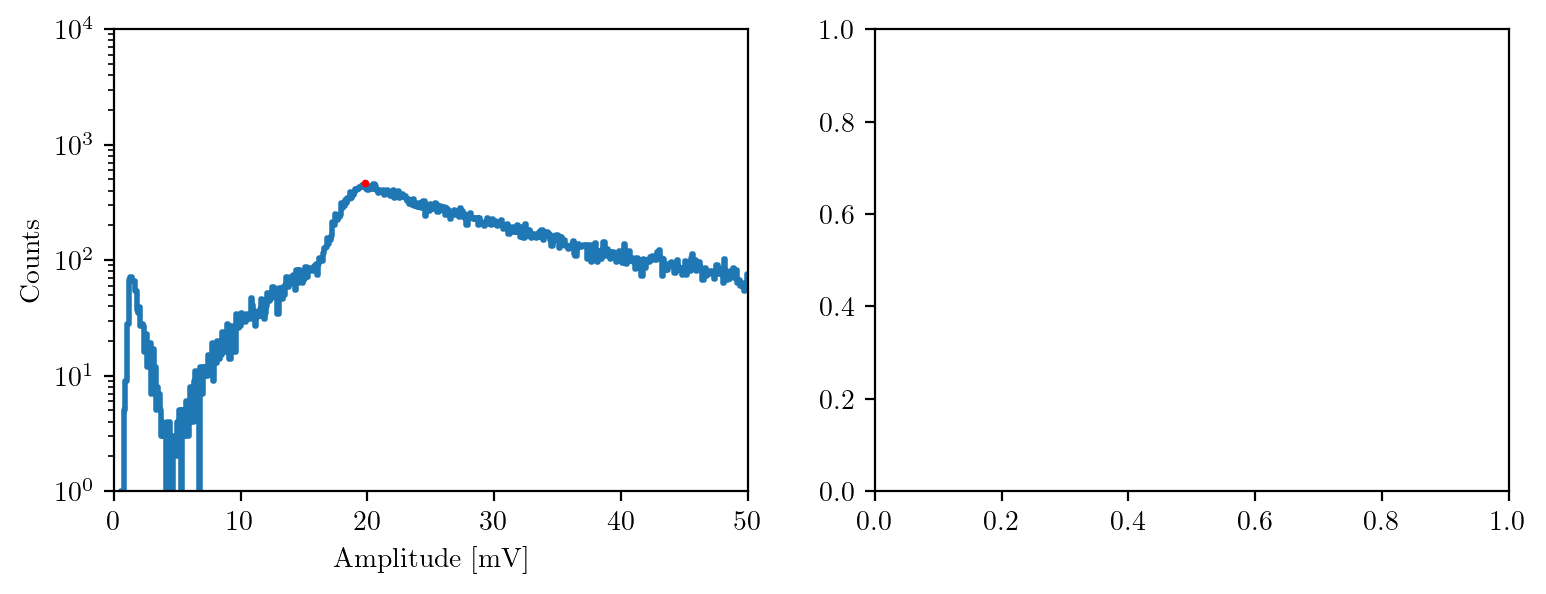

In [17]:

h,hx = np.histogram(np.abs(amp), bins=np.arange(0,1000,.1))

pp,pdict = find_peaks(h, prominence=100, width=10, distance=5)

fig, ax = plt.subplots(figsize=(9,3), ncols=2,nrows=1)
ww = 10
fit_p = []
fit_c = []

# for x in pp: 
#     popt,pcov = curve_fit(gauss, hx[:-1][x-ww:x+ww], h[x-ww:x+ww], p0=[h[x], hx[:-1][x], 2], maxfev=10000)
#     ax[0].plot(hx[:-1][x-ww:x+ww], gauss(hx[:-1][x-ww:x+ww], *popt), color=colors[1], lw=1, zorder=10)
#     fit_p.append(popt)
#     fit_c.append(pcov)

ax[0].step(hx[:-1],h, where='post')
ax[0].scatter(hx[pp], h[pp], color='r', s=3, zorder=10)
ax[0].set_xlabel('Amplitude [mV]')
ax[0].set_ylabel('Counts')
ax[0].set_yscale('log')
ax[0].set_xlim(0,50)
ax[0].set_ylim(1e0,1e4)

# popt,pcov = curve_fit(line, np.arange(1,len(fit_p)+1,1), np.array(fit_p)[:,1])
# perr = np.sqrt(np.diag(pcov))
# print(perr)
# xfit = np.linspace(0,20,100)

# gain = np.mean(np.diff(np.array(fit_p)[:,1]))
# print(gain)
# print(pp)

# ax[1].grid()
# ax[1].plot(xfit, line(xfit, *popt), color=colors[1], ls='--', label=r'$m={:.3f}\pm {:.3f}$/p.e.'.format(popt[0], perr[0]))
# ax[1].scatter(np.arange(1,len(fit_p)+1,1), np.array(fit_p)[:,1])
# ax[1].set_xlabel('Number of p.e.')
# ax[1].set_ylabel('Amplitude [a.u.]')
# ax[1].set_xlim(0,10)
# ax[1].set_ylim(0,20)
# ax[1].legend(loc='lower right')

plt.show()

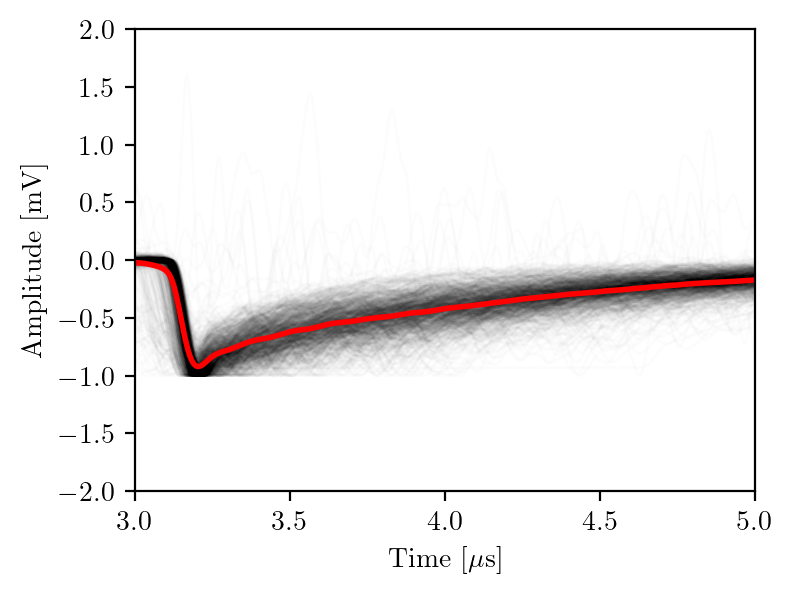

In [18]:
plt.figure()
norm_all = []
for i,wvf in enumerate(traces[::100]):
    wvf_norm = -1*wvf/np.min(wvf)
    norm_all.append(wvf_norm)
    plt.plot(tt, wvf_norm, lw=1, color='k', alpha=0.01)

mean_norm = np.mean(norm_all, axis=0)
plt.plot(tt, mean_norm, color='r')

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(0,np.max(tt))
plt.xlim(3,5)
plt.ylim(-2,2)
plt.show()

[4.50024483e-04 8.68497605e-01 3.00589795e-02 3.49024404e-02
 3.14031028e+00 1.14368758e+00]


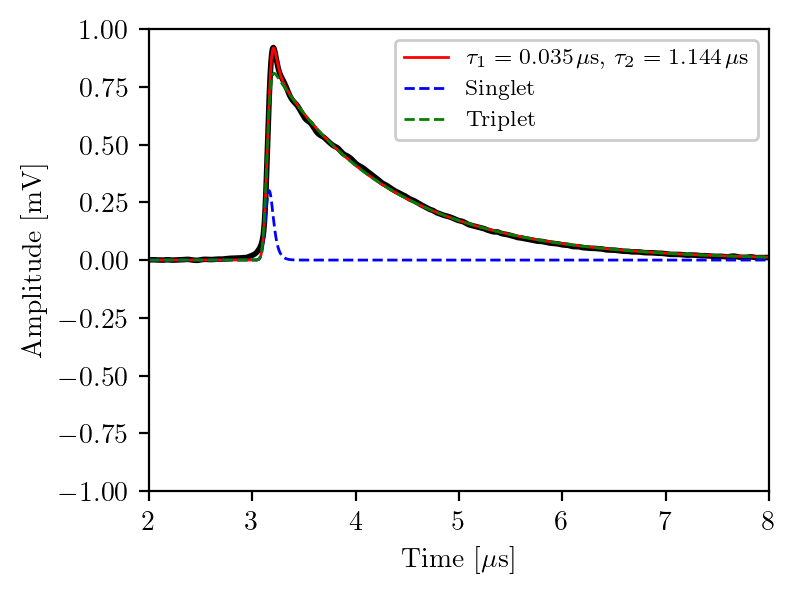

In [19]:
def func(x,a,b,c,d,e):
    return a*np.exp(-x/b)+c*np.exp(-x/d)+e
def func2(x,a,b,c):
    return a*np.exp(-x/b)+c

def func3(x,base,V0,sigma,tau,mu,tau2):
    return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) + np.exp(0.5 * (sigma/tau2)**2 - (x-mu)/tau2))

def func4(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau))

popt2,pcov2 = curve_fit(func3, tt, -1*mean_norm, maxfev=10000, p0=[0, 1, 0.1, 0.03, 3.2, 1.], bounds=([-1,0,0,0,3,1],[1,2,2,1,3.5,2]))
xfit = np.linspace(0,10,100000)
print(popt2)

plt.figure()
plt.plot(tt, -1*mean_norm, color='k')
plt.plot(xfit, func3(xfit, *popt2), color='r', ls='-', label=r"$\tau_1={:.3f}\,\mu$s, $\tau_2={:.3f}\,\mu$s".format(popt2[3], popt2[-1]), lw=1)
plt.plot(xfit, func4(xfit,  *popt2[:-1]), color='b', ls='--', label="Singlet", lw=1)
plt.plot(xfit, func4(xfit,  popt2[0], popt2[1], popt2[2], popt2[-1],popt2[4]), color='g', ls='--', label="Triplet", lw=1)

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(0,np.max(tt))
plt.xlim(2,8)
plt.ylim(-1,1)
plt.legend(loc='upper right')
plt.show()